# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://github.com/UBC-CS/cpsc330-2024s/tree/main/lectures) 
**See PrairieLearn for _due date_ and _submission instructions_**


Imports
------

In [1]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

<br><br>

## Instructions

_Points: 3_

Follow the [CPSC 330 homework submission instructions](https://github.com/UBC-CS/cpsc330-2024s/blob/main/docs/homework_instructions.md), and the summary at the end of this HW.


<br><br>

## Introducing the data set
 
For the rest of the lab you'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it under the `data` directory. 

> You will not be able to push it to your repository (hopefully) because I have seeded the repository wich `.gitignore`.

<br><br>

## Exercise 1: Exploratory data analysis

### 1.1 Loading the data
_Points: 2_

**Your tasks:**

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column (index=0) of the .csv file should be set as the index.

<div class="alert alert-warning">

Solution_1.1
    
</div>

In [2]:
spotify_df = None

spotify_df = pd.read_csv("./data/spotify.csv", index_col = 0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


<br><br>

### 1.2 Number of training and test examples

_Points: 2_

**Your tasks:**

Run the following line of code to split the data. How many training and test examples do we have? Store them in variables `n_train_samples` and `n_test_samples`, respectively.  

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [3]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=321)

<div class="alert alert-warning">

Solution_1.2
    
</div>

In [4]:
n_train_samples = len(train_df)
n_train_samples

1613

In [5]:
n_test_samples = len(test_df)
n_test_samples

404

<br><br>

#### 1.3

_Points: 3_

**Your tasks:**

1. Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
2. Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

> Note that `describe` returns another DataFrame.


<div class="alert alert-warning">

Solution_1.3
    
</div>

In [6]:
train_desc = train_df.describe()
print(train_desc)

       acousticness  danceability   duration_ms       energy  \
count   1613.000000   1613.000000  1.613000e+03  1613.000000   
mean       0.185067      0.620076  2.462533e+05     0.681315   
std        0.255838      0.161152  8.056740e+04     0.206964   
min        0.000003      0.148000  1.604200e+04     0.015600   
25%        0.010000      0.514000  1.999040e+05     0.564000   
50%        0.062600      0.634000  2.298590e+05     0.712000   
75%        0.260000      0.739000  2.703330e+05     0.841000   
max        0.994000      0.984000  1.004627e+06     0.997000   

       instrumentalness          key     liveness     loudness         mode  \
count       1613.000000  1613.000000  1613.000000  1613.000000  1613.000000   
mean           0.134317     5.384377     0.191317    -7.095272     0.619343   
std            0.274217     3.653722     0.156071     3.678993     0.485699   
min            0.000000     0.000000     0.018800   -31.082000     0.000000   
25%            0.000000     

In [7]:
max_value = train_desc.loc['max'] 
min_value = train_desc.loc['min'] 
max_value # series type

range_val = max_value - min_value
range_val

range_val.idxmin()

'speechiness'

<br><br>

### 1.4 Plotting histograms 

_Points: 5_

The starter code below produces histograms for the `loudness` feature which shows the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples. There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

> Note: I am using pandas plotting here. You can also use matplotlib if you wish. 

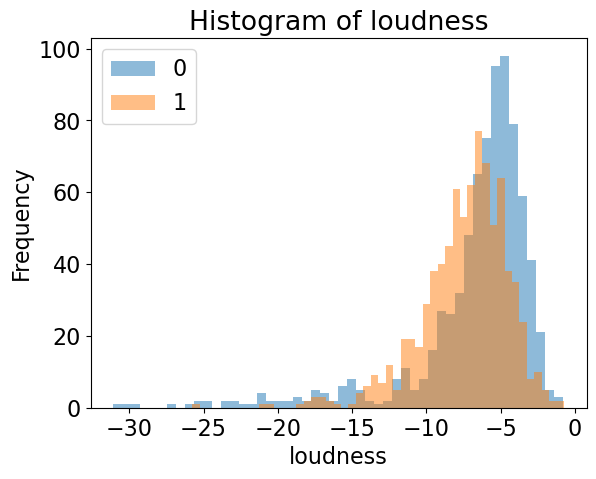

In [8]:
feat = "loudness"
ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
plt.xlabel(feat)
plt.title("Histogram of " + feat)
plt.show()

**Your tasks:**

Create histograms for the following features in the order below.
- acousticness
- danceability
- tempo
- energy
- valence

> To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

<div class="alert alert-warning">

Solution_1.4
    
</div>

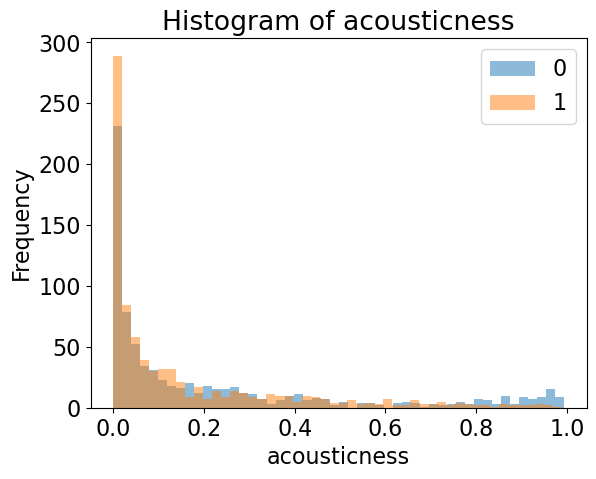

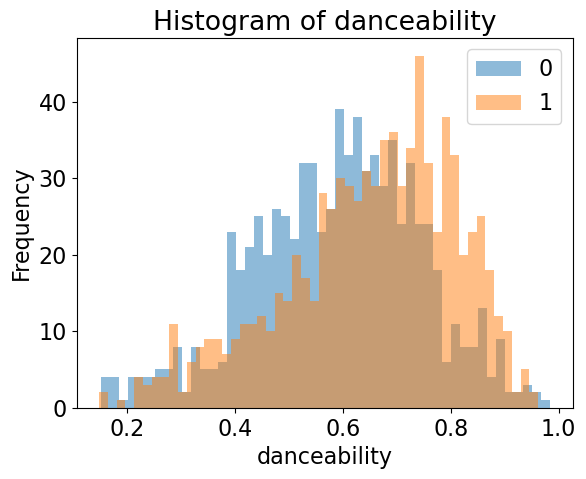

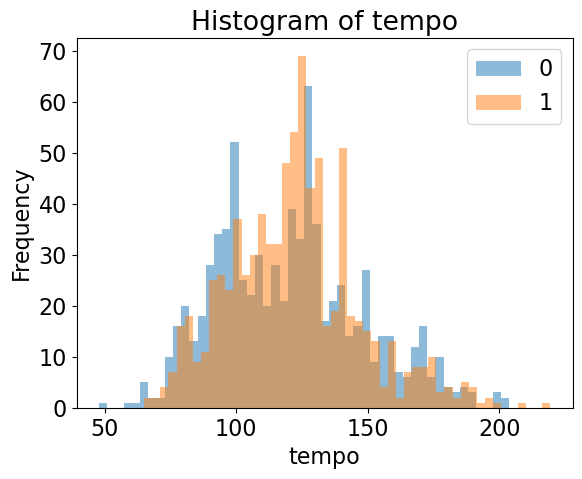

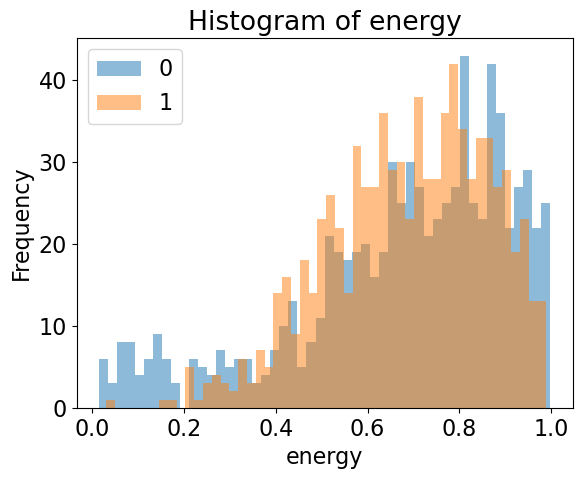

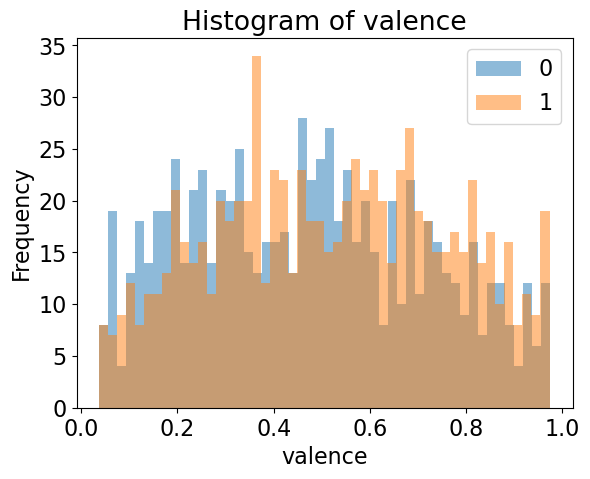

In [9]:
feats = ["acousticness", "danceability", "tempo", "energy", "valence"]

for feat in feats:
    ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

<br><br>

### 1.5 Identical histograms

_Points: 3_

**Your tasks:**

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?

<div class="alert alert-warning">

Solution_1.5
    
</div>

Yes, it would not be useful because when trying to predict the target class, we want the features to have varying results to distinguish between the 2, but when the histograms are identical, they lack the information we need to distinguish between the two.

<br><br>

### 1.6 Which columns to include? 

_Points: 4_

**Your tasks:**

Note that the dataset includes two free text features labeled `song_title` and `artist`. Do you think these features could be useful in predicting whether the user liked the song or not? Would there be any difficulty in using them in your model?   

<div class="alert alert-warning">

Solution_1.6
    
</div>

Where song_title would probably a bit too specific, I think artist can be very useful in predicting whether the user liked the song since there definitely can be a trend where a specific artist's songs are liked due to being a good artist, and artist can be used as a category. song_title on the other hand would be much harder to implement as it is much too specific since most songs only have the same name once and the data would be too sparse.

<br><br>

## Exercise 2: Using sklearn to build a decision tree classifier

<hr>
Recall that in machine learning what we care about is generalization; we want to build models that generalize well on unseen examples. One way to approximate generalization error is by splitting the data into train and test splits, building and tuning the model only using the train split, and carrying out the final assessment on the test split. 

<br><br>

### 2.1

_Points 2_

**Your tasks:**

1. Separate `X` and `y` from `train_df` and `test_df` and store them as `X_train`, `y_train`, `X_test`, `y_test`, respectively. Skip the `song_title` and `artist` columns for now. 

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [10]:
test_df
train_df
X_train = train_df.drop(columns = ["song_title", "artist", "target"])
y_train = train_df["target"]
print(y_train.head())
X_train.head()

260     1
1286    0
1344    0
1197    0
119     1
Name: target, dtype: int64


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
260,0.01810,0.932,192773,0.819,0.000007,8,0.0577,-3.484,0,0.2030,119.941,4.0,0.552
1286,0.08390,0.459,256933,0.561,0.000000,7,0.0998,-7.091,1,0.0271,144.784,4.0,0.298
1344,0.00192,0.482,198947,0.968,0.000454,6,0.1080,-4.395,1,0.1490,114.001,4.0,0.245
1197,0.03900,0.673,229507,0.758,0.000000,7,0.3410,-3.632,1,0.1580,135.956,4.0,0.541
119,0.02440,0.746,222093,0.873,0.000000,7,0.3540,-3.803,1,0.1280,148.075,4.0,0.808


In [11]:
X_test = test_df.drop(columns = ["song_title", "artist", "target"])
y_test = test_df["target"]
print(y_test.head())
X_test.head()

1489    0
1160    0
1407    0
579     1
1021    0
Name: target, dtype: int64


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1489,0.57000,0.629,250173,0.572,0.000000,5,0.1920,-7.733,0,0.0387,100.015,4.0,0.380
1160,0.00411,0.624,207520,0.806,0.000000,1,0.0872,-5.957,1,0.0437,149.999,4.0,0.536
1407,0.94700,0.483,248176,0.199,0.000000,2,0.1090,-11.370,1,0.0586,78.103,4.0,0.162
579,0.15100,0.633,321627,0.850,0.000000,5,0.0556,-5.915,0,0.3440,97.933,4.0,0.761
1021,0.06770,0.587,180252,0.628,0.000002,1,0.1220,-5.703,1,0.0431,92.003,4.0,0.650


<br><br>

### 2.2

_Points: 2_

**Your tasks:**

1. Create a `DecisionTreeClassifier` with `random_state=123` and store it in a variable called `spotify_tree`.
2. Fit the the decision tree classifier. 

<div class="alert alert-warning">

Solution_2.2
    
</div>

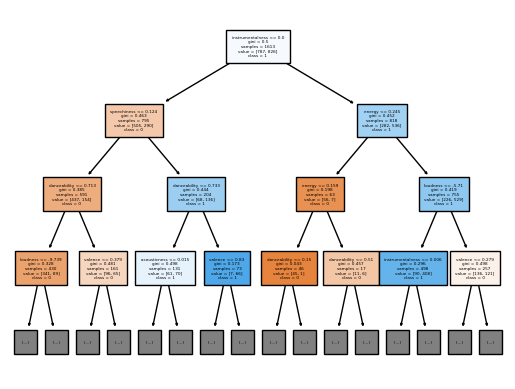

In [12]:
from sklearn.tree import plot_tree
spotify_tree = DecisionTreeClassifier(random_state=123)
spotify_tree.fit(X_train, y_train)
plot_tree(spotify_tree, 
          filled=True, 
          class_names=['0', '1'], 
          feature_names=X_train.columns, 
          fontsize=3,
          max_depth=3)
plt.show()

<br><br>

### 2.3 

_Points: 2_

**Your tasks**

1. Use the `predict` method to predict the class of the first example in your `X_train` and store the prediction in a variable called `pred` and compare it with the "true" class from `y_train`.   

> Hint: you can grab the first example with `X_train.iloc[[0]]`.

<div class="alert alert-warning">

Solution_2.3
    
</div>

In [13]:
first = X_train.iloc[[0]]
first
spotify_tree.predict(first)[0]

1

In [14]:
print(y_train.iloc[0])

1


Predict method correctly predicts the true value for the first example

<br><br>

### 2.4

_Points: 2_

**Your tasks:**

1. Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. Store the mean cross-validation accuracy in a variable called `mean_cv_score`.  


<div class="alert alert-warning">

Solution_2.4
    
</div>

In [15]:
cv_score = cross_val_score(spotify_tree, X_train, y_train, cv=10)
print(cv_score)
mean_cv_score = cv_score.mean()
mean_cv_score

[0.68518519 0.63580247 0.64197531 0.70807453 0.72670807 0.60869565
 0.71428571 0.71428571 0.67701863 0.70807453]


0.6820105820105821

<br><br>

### 2.5

_Points: 3_

The above is useful, but we would like to see the training accuracy as well. 

**Your tasks:**

1. Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True` and save the results in a variable called `scores_df` as a pandas dataframe.  

<div class="alert alert-warning">

Solution_2.5
    
</div>

In [16]:
scores_df = pd.DataFrame(cross_validate(spotify_tree, X_train, y_train, cv = 10, return_train_score = True))
scores_df.head(10)

,fit_time,score_time,test_score,train_score
0,0.023343,0.001880,0.685185,0.999311
1,0.015645,0.001496,0.635802,0.998622
2,0.013629,0.001076,0.641975,0.999311
3,0.013549,0.001074,0.708075,0.998623
4,0.013458,0.001167,0.726708,0.998623
5,0.013918,0.001062,0.608696,0.998623
6,0.012288,0.001057,0.714286,0.998623
7,0.013108,0.001180,0.714286,0.999311
8,0.012959,0.001725,0.677019,0.999311
9,0.013716,0.001071,0.708075,0.998623


<br><br>

### 2.6

_Points: 2_

**Your tasks:**
1. Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your mean cross-validation score?
2. Do you see a significant difference between the training scores and the cross-validation scores? Briefly discuss in 1 to 2 sentences.

<div class="alert alert-warning">

Solution_2.6
    
</div>

1. The test scores seem to range from around 0.64 to 0.72 and seems to vary in around 0.1 which means it is not necessarily consistent.
2. There is definitely a significant difference, where the training scores are super high (almost 1), whereas the cross validation scores are ranging at a max of 0.727 and according to scikit (https://scikit-learn.org/stable/modules/learning_curve.html), this means that there is some over-fitting going on

<br><br><br><br>

## Exercise 3: Hyperparameters 

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

### 3.1

_Points: 10_

**Your tasks:**

1. Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25). 
2. For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
3. Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which. Store the plot in a variable called `max_depth_plot` for autograding. 


> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

In [17]:
depths = np.arange(1, 25, 2)
depths

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

<div class="alert alert-warning">

Solution_3.1
    
</div>

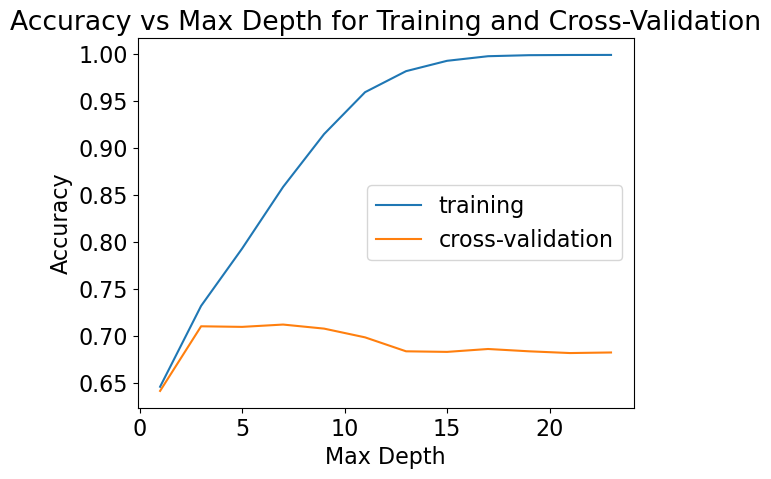

In [22]:
train_scores = []
cv_scores = []

# Create a tree for each depth and append it to the scores
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=123)
    scores = cross_validate(tree, X_train, y_train, cv=10, return_train_score=True)
    train_scores.append(np.mean(scores['train_score'])) # accuracy represented by the mean
    cv_scores.append(np.mean(scores['test_score'])) # accuracy represented by the mean

# plot the scores train_scores vs cv_scores
max_depth_plot = plt.figure()
plt.plot(depths, train_scores, label="Train Accuracy")
plt.plot(depths, cv_scores, label="Cross-Validation Accuracy")
plt.legend(['training', 'cross-validation'])
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for Training and Cross-Validation')
plt.show()

<br><br>

### 3.2 `max_depth` and the fundamental tradeoff

_Points: 2_

**Your tasks:**

Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy.

<div class="alert alert-warning">

Solution_3.2
    
</div>

The max_depth hyperparameter creates more complex boundaries, as seen in lecture 2, where it finds many more subtle, possibly unrelated, patterns which is very visible in the training accuracy in the plot above. As the max depth increases, the accuracy increases substantially and almost becoming perfect as a result of the super complex model created for subtle outlying patterns mentioned.

On the other hand, in cross-validation accuracy, we see it rapidly increase as the max depth increases and peaks at around 3 then starts decreasing after that. The original peak is most likely due to the model picking up the important/large patterns in the data, then once becoming too complex, starts negatively affecting the accuracy.

In summary, looking at this plot makes me assume that where the 2 methods meet, should be around when it is the most realistic model, and everything after that becomes too complex/specific

<br><br>

### 3.3 Picking a reasonable value for `max_depth`

_Points: 2_

**Your tasks:**

From these results, what value for max_depth would you pick as the optimal value? Store it in the variable called `best_max_depth` below. 

<div class="alert alert-warning">

Solution_3.3
    
</div>

In [19]:
best_max_depth = 3

I chose 3 with the same reasoning I mentioned in (3.2), since that is where both methods have around the same accuracy, and seems to also be when the linear increase of accuracy stops, later becoming inconsistent

<br><br>

### 3.4 Final assessment on the test set

_Points: 3_

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

**Your tasks:**
1. Train a decision tree classifier using the optimal _max_depth_ you chose in the previous exercise on the entire training set.
2. Compute and store it in a variable called `test_score`. 

<div class="alert alert-warning">

Solution_3.4
    
</div>

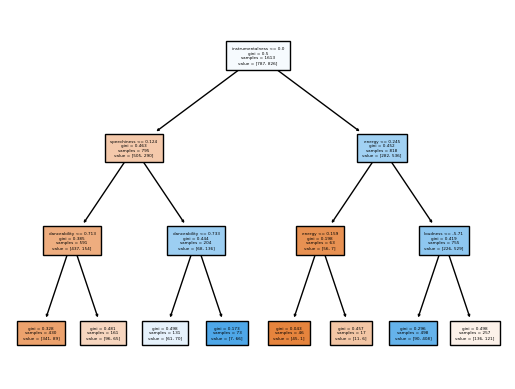

0.6683168316831684

In [29]:
# part 1
optimal_tree = DecisionTreeClassifier(max_depth = best_max_depth, random_state = 123)
optimal_tree.fit(X_train, y_train)
plot_tree(optimal_tree, 
          filled=True, 
          feature_names=X_train.columns, 
          fontsize=3)
plt.show()
# part 2
test_score = optimal_tree.score(X_test, y_test)
test_score

<br><br>

### 3.5 Analysis

_Points: 5_

**Your tasks:**

1. How do the test scores compare to the cross-validation scores? Briefly discuss.
2. Why can't you simply pick the value of `max_depth` that gives the best accuracy on the training data? (Answer in maximum 2 to 3 sentences.)
3. Do you think that the max_depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

<div class="alert alert-warning">

Solution_3.5
    
</div>

In [21]:
# mean of the cross-validation scores for comparison from earlier
mean_cv_score

0.6820105820105821

1. The test scores seem to be really close to the average of the cross validation scores while being slightly higher, and this is most likely related to the previous point where the optimal_max_depth on the chart had very similar accuracies for the two methods, resulting in the test_score we have.
2. As previously mentioned, as max_depth increases, the patterns recognized by the model become unrealistic patterns and there is a peak where the accuracy is consistent, then becomes inconsistent after as the model becomes too complex.
3. It depends, if the data distribution is similar and has a similar number of samples, it probably would work to generalize it. If the distribution of the features was not similar, however, then the patterns our decision tree would pick up might change (for example only loud songs)

<br><br><br><br>

## Exercise 4: Conceptual questions

_Points: 3_

Consider the dataset below, which has $6$ examples and $2$ features:

$$X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\+1\\+1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

<div class="alert alert-warning">

Solution_4
    
</div>

1. **True Cases (left column < 5.5)**: Row 1, Row 2, Row 3. Prediction would be -1 (majority)<br /> 
   **False Cases (left column >= 5.5)**: Row 4, Row 5, Row 6. Prediction would be +1

2. We have 5 correct predictions using the above, and one incorrect prediction (row 3 is +1 instead of predicted -1)<br />
   Therefore the accuracy would be 5/6 = ~83.3333%

3. No, due to the fact that there is mixed symbols in the y column for the true case, there will not be 100% accuracy in this particular example

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using PrairieLearn.
4. Make sure that the plots and output are rendered properly in your submitted file.